Poletti Modeling - original, additional compartments part 2 (age structuring, in addition to Exposed and Death)


In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib


This defines the functions necessary for age structuring - the code seems to work - am in the process of exploring effects via graphs.

- make sure that the structure of the model makes sense

In [2]:
def payoff_difference(M):
    
#    P_n = -m_n*M
#    P_a = -k - m_a*M
#    Delta_P = P_n-P_a # k - (m_n-m_a)*M  # most intuitive
    
    Delta_P  = 1-m*M  # k*(1-m*M) = the real Delta_P  # note: divided by extra k that will be fixed with rho
    
    return Delta_P

In [3]:
def plot_SEIRDbig(time, solution, reg_SIR=False):
    

    matplotlib.rcParams['figure.figsize'] = [22, 22]
    fig, ax = plt.subplots()

    Se = solution[:,0]+solution[:,1]
    Ee = solution[:,4]+solution[:,5]
    Ie = solution[:,8]+solution[:,9]+solution[:,10]
    Re = solution[:,16]+solution[:,17]+solution[:,18]
    De = solution[:,14]
    
    Sy = solution[:,2]+solution[:,3]
    Ey = solution[:,6]+solution[:,7]
    Iy = solution[:,11]+solution[:,12]+solution[:,13]
    Ry = solution[:,19]+solution[:,20]+solution[:,21]
    Dy = solution[:,15]

    
    Se_curve, = ax.plot(time, Se, color='blue')
    Ee_curve = ax.plot(time, Ee, color = 'yellow')
    Ie_curve, = ax.plot(time, Ie, color = 'red')
    Re_curve, = ax.plot(time, Re, color = 'green')
    De_curve = ax.plot(time, De, color = 'black')

    

    Sy_curve, = ax.plot(time, Sy, color='blue',linestyle='dashed')
    Ey_curve = ax.plot(time, Ey, color = 'yellow', linestyle='dashed')
    Iy_curve, = ax.plot(time, Iy, color = 'red', linestyle='dashed')
    Ry_curve, = ax.plot(time, Ry, color = 'green', linestyle='dashed')
    Dy_curve, = ax.plot(time, Dy, color = 'black', linestyle='dashed')


    
    ax.set(xlabel='time (days)', ylabel='SEIRD big Dynamics')
    ax.set_ylim((0,1))
    ax.grid()


    return

In [7]:

def force_of_infectioney(Ie_S, Ie_An, Ie_Aa, Iy_S, Iy_An, Iy_Aa):

    return beta_S*(Ie_S+Iy_S)+beta_A*(Ie_An+Iy_An)+qe*beta_A*Ie_Aa+qy*beta_A*Iy_Aa


def ODE_systembig(State_vector,t):
    
#    epi_compartments = State_vector[:num_compartments]
#    behavior_variables = State_vector[num_compartments:]
    
    epi_compartments = State_vector[:-2]
    behavior_variables = State_vector[-2:]
    
    Se_n, Se_a, Sy_n, Sy_a, Ee_n, Ee_a, Ey_n, Ey_a, Ie_S, Ie_An, Ie_Aa, Iy_S, Iy_An, Iy_Aa, De, Dy, Re_S, Re_An, Re_Aa, Ry_S, Ry_An, Ry_Aa = epi_compartments
    Me, My = behavior_variables
    
    lambda_t = force_of_infectioney(Ie_S, Ie_An, Ie_Aa, Iy_S, Iy_An, Iy_Aa)
    
    ### first establish the transmission dynamics ###
    Sen_dot = -lambda_t*Se_n
    Sea_dot = - qe*lambda_t*Se_a #different rate of distancing among people who are in e
    
    Syn_dot = -lambda_t*Sy_n
    Sya_dot = - qy*lambda_t*Sy_a #different rate of distancing among people who are in y
    
    Een_dot = lambda_t*Se_n - xi*Ee_n #currently, assume xi the same
    Eea_dot = qe*lambda_t*Se_a - xi*Ee_a
    
    Eyn_dot = lambda_t*Sy_n - xi*Ey_n
    Eya_dot = qy*lambda_t*Sy_a - xi*Ey_a
    
    IeS_dot  = pe*xi*(Ee_n + qe*Ee_a) - gammae*Ie_S
    IeAn_dot = (1-pe)*xi*Ee_n - gammae*Ie_An
    IeAa_dot = (1-pe)*qe*xi*Ee_a - gammae*Ie_Aa   
    
    IyS_dot  = py*xi*(Ey_n + qy*Ey_a) - gammay*Iy_S
    IyAn_dot = (1-py)*xi*Ey_n - gammay*Iy_An
    IyAa_dot = (1-py)*qy*xi*Ey_a - gammay*Iy_Aa
    
    '''
     IeS_dot  = pe*xi*(Ee_n + Ee_a) - gammae*Ie_S
    IeAn_dot = (1-pe)*xi*Ee_n - gammae*Ie_An
    IeAa_dot = (1-pe)*qe*xi*Ee_a - gammae*Ie_Aa   
    
    IyS_dot  = py*xi*(Ey_n + Ey_a) - gammay*Iy_S
    IyAn_dot = (1-py)*xi*Ey_n - gammay*Iy_An
    IyAa_dot = (1-py)*qy*xi*Ey_a - gammay*Iy_Aa
    '''
    
    ReS_dot  = (gammae - deathe)*Ie_S
    ReAn_dot = gammae*Ie_An
    ReAa_dot = gammae*Ie_Aa
    
    RyS_dot  = (gammay - deathy)*Iy_S
    RyAn_dot = gammay*Iy_An
    RyAa_dot = gammay*Iy_Aa
    
    
    De_dot = deathe*Ie_S
    Dy_dot = deathy*Iy_S
    
    
    Deltae_P = payoff_difference(Me) #note: this still has extra k divided 
    Deltay_P = payoff_difference(My)
    
    ## intra-compartment imitation:
    
    Sen_dot += rho*(Se_n*Se_a*Deltae_P + mue*Se_a - mue*Se_n)
    Sea_dot += -rho*(Se_n*Se_a*Deltae_P + mue*Se_a - mue*Se_n)
    
    Syn_dot += rho*(Sy_n*Sy_a*Deltay_P + muy*Sy_a - muy*Sy_n)
    Sya_dot += -rho*(Sy_n*Sy_a*Deltay_P + muy*Sy_a - muy*Sy_n)
    
    Een_dot += rho*(Ee_n*Ee_a*Deltae_P + mue*Ee_a - mue*Ee_n)
    Eea_dot += -rho*(Ee_n*Ee_a*Deltae_P + mue*Ee_a - mue*Ee_n)
    
    Eyn_dot += rho*(Ey_n*Ey_a*Deltay_P + muy*Ey_a - muy*Ey_n)
    Eya_dot += -rho*(Ey_n*Ey_a*Deltay_P + muy*Ey_a - muy*Ey_n)
    
    IeAn_dot += rho*(Ie_An*Ie_Aa*Deltae_P + mue*Ie_Aa - mue*Ie_An)
    IeAa_dot += -rho*(Ie_An*Ie_Aa*Deltae_P + mue*Ie_Aa - mue*Ie_An)
    
    IyAn_dot += rho*(Iy_An*Iy_Aa*Deltay_P + muy*Iy_Aa - muy*Iy_An)
    IyAa_dot += -rho*(Iy_An*Iy_Aa*Deltay_P + muy*Iy_Aa - muy*Iy_An)
    
    ReAn_dot += rho*(Re_An*Re_Aa*Deltae_P + mue*Re_Aa - mue*Re_An)
    ReAa_dot += -rho*(Re_An*Re_Aa*Deltae_P + mue*Re_Aa - mue*Re_An)
    
    RyAn_dot += rho*(Ry_An*Ry_Aa*Deltay_P + muy*Ry_Aa - muy*Ry_An)
    RyAa_dot += -rho*(Ry_An*Ry_Aa*Deltay_P + muy*Ry_Aa - muy*Ry_An)
    
    
     ## inter-compartment imitation:
        
        ## right now, am assuming that only comparing with people within compartment
    
    # if Delta_P >0:
    
    Sen_dot +=  rho*Se_a*(Ee_n+Ie_An+Re_An)*Deltae_P*np.heaviside(Deltae_P,0)
    Sea_dot += -rho*Se_a*(Ee_n+Ie_An+Re_An)*Deltae_P*np.heaviside(Deltae_P,0)
    
    Syn_dot +=  rho*Sy_a*(Ey_n+Iy_An+Ry_An)*Deltay_P*np.heaviside(Deltay_P,0)
    Sya_dot += -rho*Sy_a*(Ey_n+Iy_An+Ry_An)*Deltay_P*np.heaviside(Deltay_P,0)
    
    Een_dot += rho*Ee_a*(Se_n+Ie_An+Re_An)*Deltae_P*np.heaviside(Deltae_P,0)
    Eea_dot += -rho*Ee_a*(Se_n+Ie_An+Re_An)*Deltae_P*np.heaviside(Deltae_P,0)
    
    Eyn_dot += rho*Ey_a*(Sy_n+Iy_An+Ry_An)*Deltay_P*np.heaviside(Deltay_P,0)
    Eya_dot += -rho*Ey_a*(Sy_n+Iy_An+Ry_An)*Deltay_P*np.heaviside(Deltay_P,0)
    
    IeAn_dot +=  rho*Ie_Aa*(Se_n+Ee_n+Re_An)*Deltae_P*np.heaviside(Deltae_P,0)
    IeAa_dot += -rho*Ie_Aa*(Se_n+Ee_n+Re_An)*Deltae_P*np.heaviside(Deltae_P,0)
    
    IyAn_dot +=  rho*Iy_Aa*(Sy_n+Ey_n+Ry_An)*Deltay_P*np.heaviside(Deltay_P,0)
    IyAa_dot += -rho*Iy_Aa*(Sy_n+Ey_n+Ry_An)*Deltay_P*np.heaviside(Deltay_P,0)
    
    ReAn_dot +=  rho*Re_Aa*(Ee_n+Ie_An+Se_n)*Deltae_P*np.heaviside(Deltae_P,0)
    ReAa_dot += -rho*Re_Aa*(Ee_n+Ie_An+Se_n)*Deltae_P*np.heaviside(Deltae_P,0)
    
    RyAn_dot +=  rho*Ry_Aa*(Ey_n+Iy_An+Sy_n)*Deltay_P*np.heaviside(Deltay_P,0)
    RyAa_dot += -rho*Ry_Aa*(Ey_n+Iy_An+Sy_n)*Deltay_P*np.heaviside(Deltay_P,0)
    
    # if Delta_P <0
    
    Sen_dot +=  rho*Se_n*(Ee_a+Ie_Aa+Re_Aa)*Deltae_P*np.heaviside(-Deltae_P,0)
    Sea_dot += -rho*Se_n*(Ee_a+Ie_Aa+Re_Aa)*Deltae_P*np.heaviside(-Deltae_P,0)
    
    Een_dot += rho*Ee_n*(Se_a+Ie_Aa+Re_Aa)*Deltae_P*np.heaviside(-Deltae_P,0)
    Eea_dot += -rho*Ee_n*(Se_a+Ie_Aa+Re_Aa)*Deltae_P*np.heaviside(-Deltae_P,0)
    
    IeAn_dot +=  rho*Ie_An*(Se_a+Ee_a+Re_Aa)*Deltae_P*np.heaviside(-Deltae_P,0)
    IeAa_dot += -rho*Ie_An*(Se_a+Ee_a+Re_Aa)*Deltae_P*np.heaviside(-Deltae_P,0)
    
    ReAn_dot +=  rho*Re_An*(Ie_Aa+Ee_a+Se_a)*Deltae_P*np.heaviside(-Deltae_P,0)
    ReAa_dot += -rho*Re_An*(Ie_Aa+Ee_a+Se_a)*Deltae_P*np.heaviside(-Deltae_P,0)
    
    Syn_dot +=  rho*Sy_n*(Ey_a+Iy_Aa+Ry_Aa)*Deltay_P*np.heaviside(-Deltay_P,0)
    Sya_dot += -rho*Sy_n*(Ey_a+Iy_Aa+Ry_Aa)*Deltay_P*np.heaviside(-Deltay_P,0)
    
    Eyn_dot += rho*Ey_n*(Sy_a+Iy_Aa+Ry_Aa)*Deltay_P*np.heaviside(-Deltay_P,0)
    Eya_dot += -rho*Ey_n*(Sy_a+Iy_Aa+Ry_Aa)*Deltay_P*np.heaviside(-Deltay_P,0)
    
    IyAn_dot +=  rho*Iy_An*(Sy_a+Ey_a+Ry_Aa)*Deltay_P*np.heaviside(-Deltay_P,0)
    IyAa_dot += -rho*Iy_An*(Sy_a+Ey_a+Ry_Aa)*Deltay_P*np.heaviside(-Deltay_P,0)
    
    RyAn_dot +=  rho*Ry_An*(Iy_Aa+Ey_a+Sy_a)*Deltay_P*np.heaviside(-Deltay_P,0)
    RyAa_dot += -rho*Ry_An*(Iy_Aa+Ey_a+Sy_a)*Deltay_P*np.heaviside(-Deltay_P,0)
    
    Me_dot = pe*(xi*(Ee_n + Ee_a+Ey_n + Ey_a)) - nu*Me #currently, determined by all exposed
    My_dot = py*(xi*(Ee_n + Ee_a+Ey_n + Ey_a)) - nu*My
    
        
    deriv = np.array([Sen_dot,Sea_dot,Syn_dot,Sya_dot,Een_dot,Eea_dot,Eyn_dot,Eya_dot,IeS_dot, IeAn_dot, IeAa_dot,IyS_dot, IyAn_dot, IyAa_dot, De_dot, Dy_dot, ReS_dot, ReAn_dot, ReAa_dot, RyS_dot, RyAn_dot, RyAa_dot, Me_dot, My_dot])

    return deriv






In [8]:
k = 0

recovery_dayse = 4 # average length of infection (current baseline from 2012)
gammae = 1/recovery_dayse # rate of recovery for elderly group

recovery_daysy = 2 # average length of infection (current baseline from 2012)
gammay = 1/recovery_daysy # rate of recovery (you)

beta_S = 0.5 # infection rate for symptomatic infectives
beta_A = 0.5 # infection rate for asymptomatic infectives

xi = 0.33333

qe = 0.3  # reduction factor for those with altered/adjusted behavior
pe = 0.98     # probability of developing symptoms

qy = 0.5  # reduction factor for those with altered/adjusted behavior (young group)
py = 0.9     # probability of developing symptoms

deathe = 0.01
deathy = 0.08

avg_memory = 2.8   # average length of memory regarding active cases
nu  = 1/avg_memory  # rate of forgetting past "new case" counts

M_thresh = 0.01 # risk threshold 
m = 1/M_thresh

rho = 10 # speed of behavioral changes (1/days)

mue = 10**(-8)  # irrational exploration with fixed units
muy = 10**(-8)  # irrational exploration with fixed units (currently left the same across age group)

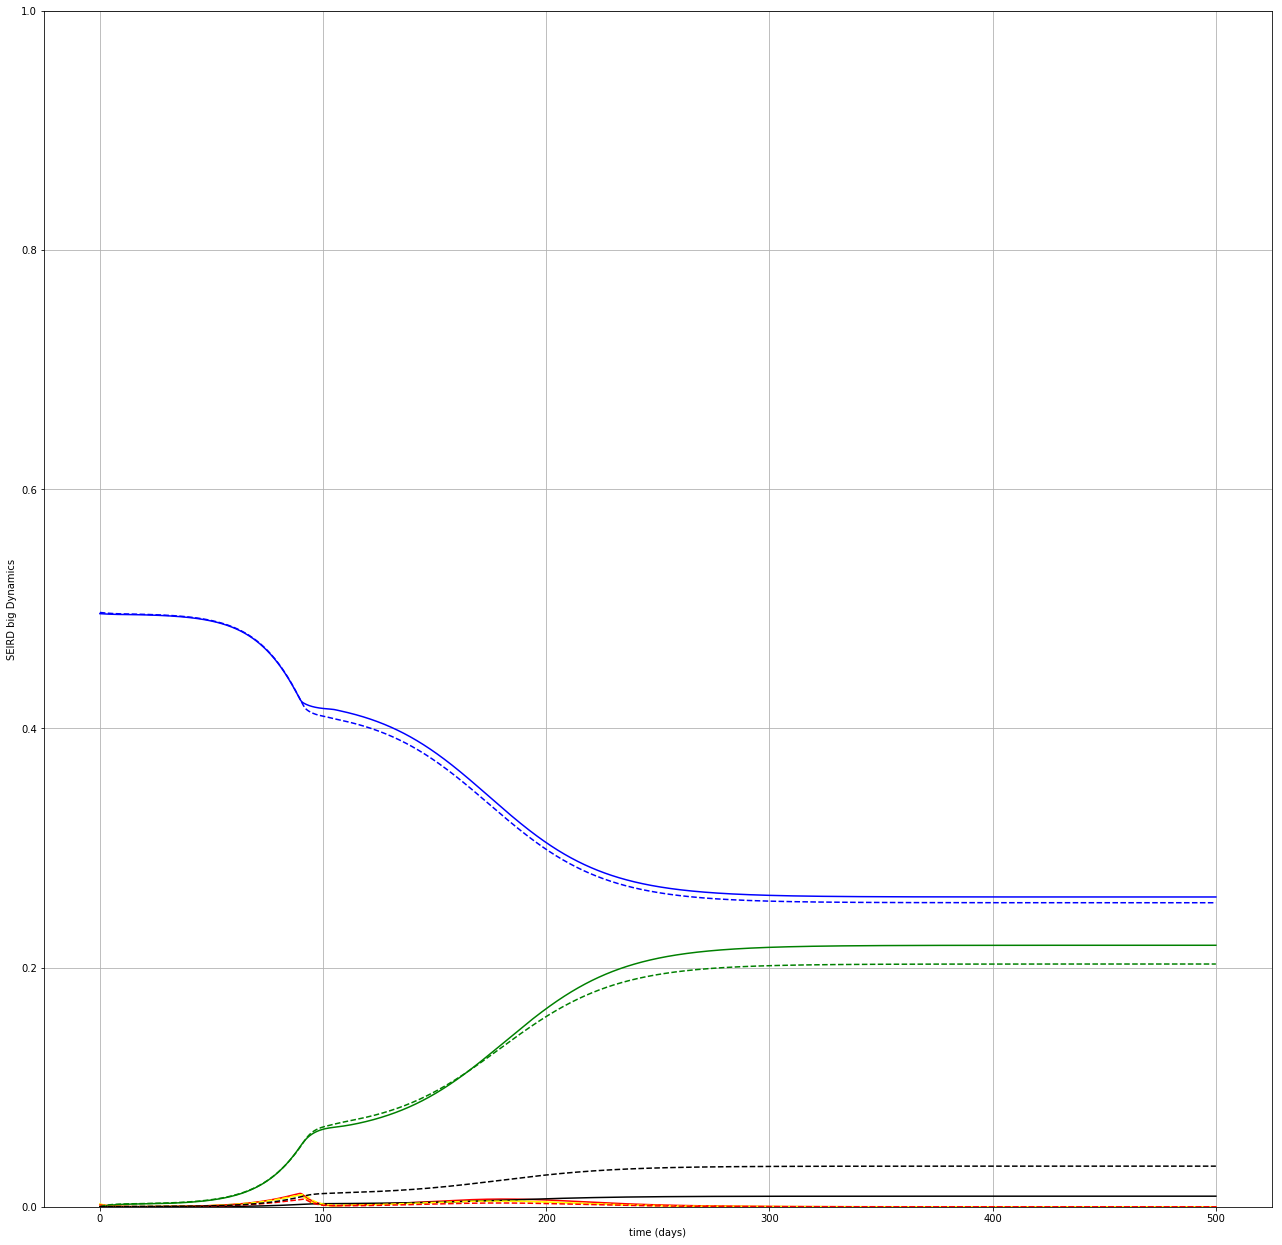

In [12]:
def main1():
    
    Sen_0  = 0.495
    Sea_0  = 0.001
    Een_0 = 0.001
    Eea_0 = 0.0015
    IeS_0  = 0.0005
    IeAn_0 = 0.001
    IeAa_0 = 0
    ReS_0  = 0
    ReAn_0 = 0
    ReAa_0 = 0
    De_0 = 0
    Syn_0  = 0.495
    Sya_0  = 0.002
    Eyn_0 = 0.001
    Eya_0 = 0.0005
    IyS_0  = 0.0005
    IyAn_0 = 0.001
    IyAa_0 = 0
    RyS_0  = 0
    RyAn_0 = 0
    RyAa_0 = 0
    Dy_0 = 0
    
    My_0 = 0.3  # prior belief of risk (or "overestimation" of risk)
    Me_0 = 0.4
    initial_stateEY = np.array([Sen_0,Sea_0,Syn_0,Sya_0,Een_0,Eea_0,Eyn_0,Eya_0,IeS_0,IeAn_0,IeAa_0,IyS_0,IyAn_0,IyAa_0,De_0, Dy_0,ReS_0,ReAn_0,ReAa_0,RyS_0,RyAn_0,RyAa_0,Me_0,My_0])
    
    if np.sum(initial_stateEY)- (My_0+Me_0) != 1:
        print("Error: make sure population sums to 1")
        return
    
    t = np.arange(0,500,0.0005)
    
    solutionbig = odeint(ODE_systembig,initial_stateEY,t)
#    solution = odeint(SIR_system, np.array([0.99,0.01,0]),t)
    
    plot_SEIRDbig(t, solutionbig)
    
    
    return

main1()

Above graph - trajectory finally seems reasonable (no more strange spike of deaths) - however, am not sure why deaths for young category so much higher. (Too reduced social distancing? - not sure if this is a flaw in the model).

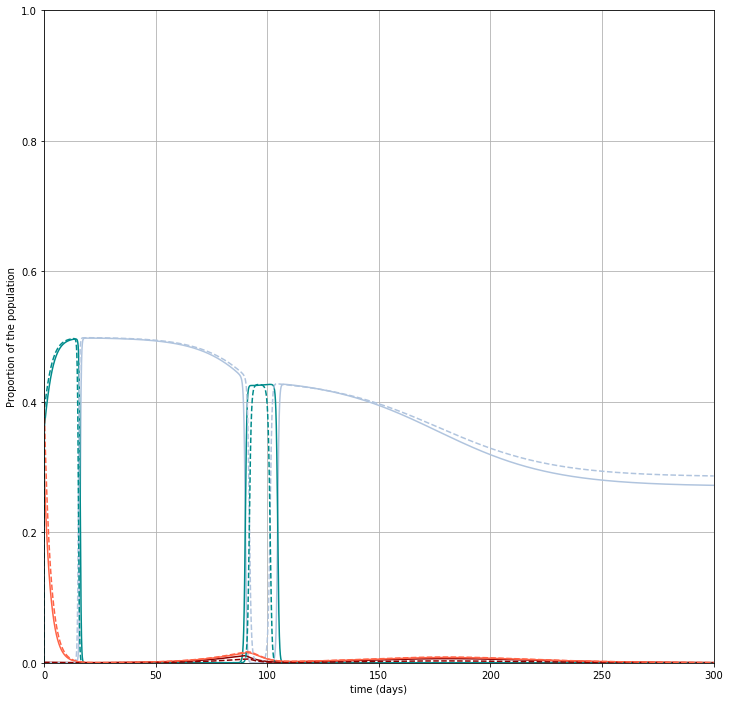

In [22]:
## Plot combined I_S and M with x
Sen_0  = 0.495
Sea_0  = 0.001
Een_0 = 0.001
Eea_0 = 0.0015
IeS_0  = 0.0005
IeAn_0 = 0.001
IeAa_0 = 0
ReS_0  = 0
ReAn_0 = 0
ReAa_0 = 0
De_0 = 0
Syn_0  = 0.495
Sya_0  = 0.002
Eyn_0 = 0.001
Eya_0 = 0.0005
IyS_0  = 0.0005
IyAn_0 = 0.001
IyAa_0 = 0
RyS_0  = 0
RyAn_0 = 0
RyAa_0 = 0
Dy_0 = 0
My_0 = 0.3  # prior belief of risk (or "overestimation" of risk)
Me_0 = 0.4
    
time = np.arange(0,500,0.0005)


initial_stateEY = np.array([Sen_0,Sea_0,Syn_0,Sya_0,Een_0,Eea_0,Eyn_0,Eya_0,IeS_0,IeAn_0,IeAa_0,IyS_0,IyAn_0,IyAa_0,De_0, Dy_0,ReS_0,ReAn_0,ReAa_0,RyS_0,RyAn_0,RyAa_0,Me_0,My_0])


solution = odeint(ODE_systembig,initial_stateEY,time)

fin_time = 300

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

nonbehaviore_comparts = solution[:,4]+solution[:,9]
nonbehaviory_comparts = solution[:,6]+solution[:,12]

xe = (solution[:,0]+solution[:,4]+solution[:,9]+solution[:,17])/(np.sum(solution,axis=1)-nonbehaviore_comparts-solution[:,-1])
x1e = (solution[:,1]+solution[:,5]+solution[:,10]+solution[:,18])/(np.sum(solution,axis=1)-nonbehaviore_comparts-solution[:,-1])
Ie_S = solution[:,8]
Me = solution[:,-1]

x_curve, = ax.plot(time, xe, linestyle='-', c='lightsteelblue')
x1_curve, = ax.plot(time, x1e, linestyle='-', c='darkcyan')
IS_curve, = ax.plot(time, Ie_S, linestyle='-', c='darkred')
M_curve, = ax.plot(time, Me, linestyle='-', c='tomato')

xy = (solution[:,2]+solution[:,6]+solution[:,12]+solution[:,20])/(np.sum(solution,axis=1)-nonbehaviory_comparts-solution[:,-2])
x1y = (solution[:,3]+solution[:,7]+solution[:,13]+solution[:,21])/(np.sum(solution,axis=1)-nonbehaviory_comparts-solution[:,-2])
Iy_S = solution[:,11]
My = solution[:,-2]

x_curve, = ax.plot(time, xy, linestyle='dashed', c='lightsteelblue')
x1_curve, = ax.plot(time, x1y, linestyle='dashed', c='darkcyan')
IS_curve, = ax.plot(time, Iy_S, linestyle='dashed', c='darkred')
M_curve, = ax.plot(time, My, linestyle='dashed', c='tomato')

ax.set(xlabel='time (days)', ylabel='Proportion of the population')
ax.set_ylim((0,1))
ax.set_xlim((0,fin_time))
ax.grid()






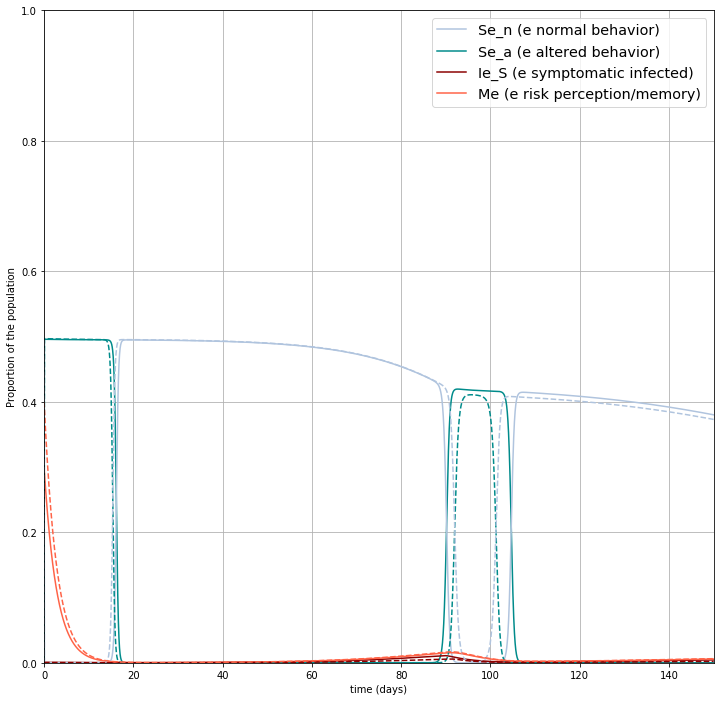

In [24]:
## Plot combined I_S and M with x

fin_time = 150

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

Se_a = solution[:,1]
Se_n = solution[:,0]
Ie_S = solution[:,8]
Me   = solution[:,-1]

Sy_a = solution[:,3]
Sy_n = solution[:,2]
Iy_S = solution[:,11]
My   = solution[:,-2]

Sea_curve, = ax.plot(time, Se_a, linestyle='-', c='darkcyan')
Sen_curve, = ax.plot(time, Se_n, linestyle='-', c='lightsteelblue')
IeS_curve, = ax.plot(time, Ie_S, linestyle='-', c='darkred')
Me_curve, = ax.plot(time, Me, linestyle='-', c='tomato')

Sya_curve, = ax.plot(time, Sy_a, linestyle='dashed', c='darkcyan')
Syn_curve, = ax.plot(time, Sy_n, linestyle='dashed', c='lightsteelblue')
IyS_curve, = ax.plot(time, Iy_S, linestyle='dashed', c='darkred')
My_curve, = ax.plot(time, My, linestyle='dashed', c='tomato')

ax.set(xlabel='time (days)', ylabel='Proportion of the population')
ax.set_ylim((0,1))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend((Sen_curve,Sea_curve,IeS_curve,Me_curve),
          ('Se_n (e normal behavior)','Se_a (e altered behavior)','Ie_S (e symptomatic infected)','Me (e risk perception/memory)', 'Sy_n (y normal behavior)','Sy_a (y altered behavior)','Iy_S (y symptomatic infected)','My (y risk perception/memory)'),
          loc='best',fontsize='x-large')